This notebook presents a first baseline for CommonLit Readability Competition, using a pretrained DistilBert as feature extractor and a standard regression model for prediciton.
It can be used on original train text or preprocessed text (stopwords, ponctuation removed).
Some special features have been added to try to catch the text complexity and add it as an input for regression in case the prepocessed text is used. It should be a way to keep the knowledge of the text structure.

In [1]:
# ! pip install transformers
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import torch
import transformers as ppb # pytorch transformers

from sklearn import metrics
from sklearn import kernel_ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
# get train data
train_file = '../input/commonlitreadabilityprize/train.csv'
data_train =  pd.read_csv(train_file)
data_train

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


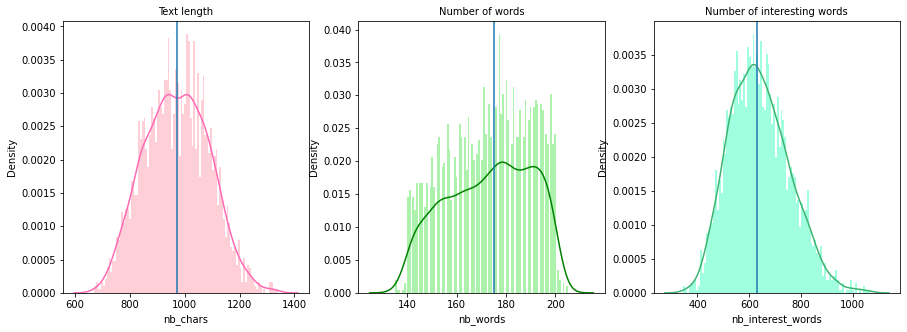

In [3]:
# explore excerpt
data_train['nb_words'] = data_train.excerpt.apply(lambda x: len(x.split()))
data_train['nb_chars'] = data_train.excerpt.apply(lambda x: len(x))

# process text : remove ponctuation and stopwords
list_sw = stopwords.words("english")
sw = set(list_sw)

def remove_stopwords(text):
    """removes ponctuation and stop words"""
    text = re.sub("[^a-zA-Z0-9]",   " ",  text)  
    words = text.split()
    interest_words = [w for w in words if not w in sw]
    return ' '.join(interest_words).lower()

data_train['interest_words'] = data_train.excerpt.apply(remove_stopwords)
data_train['nb_interest_words'] = data_train.interest_words.apply(lambda x: len(x))

# plot histograms
fix, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=data_train, x="nb_chars", bins=100, ax=ax[0],
             color='pink', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="nb_chars", color='hotpink', ax=ax[0])
ax[0].axvline(np.median(data_train.nb_chars), 0, np.max(data_train.nb_chars))
ax[0].set_title('Text length', fontsize=10)

sns.histplot(data=data_train, x="nb_words", bins=100, ax=ax[1],
             color='lightgreen', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="nb_words", color='green', ax=ax[1])
ax[1].axvline(np.median(data_train.nb_words), 0, np.max(data_train.nb_words))
ax[1].set_title('Number of words', fontsize=10)

sns.histplot(data=data_train, x="nb_interest_words", bins=100, ax=ax[2],
             color='aquamarine', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="nb_interest_words", color='mediumseagreen', ax=ax[2])
ax[2].axvline(np.median(data_train.nb_interest_words), 0, np.max(data_train.nb_interest_words))
ax[2].set_title('Number of interesting words', fontsize=10)

plt.show()

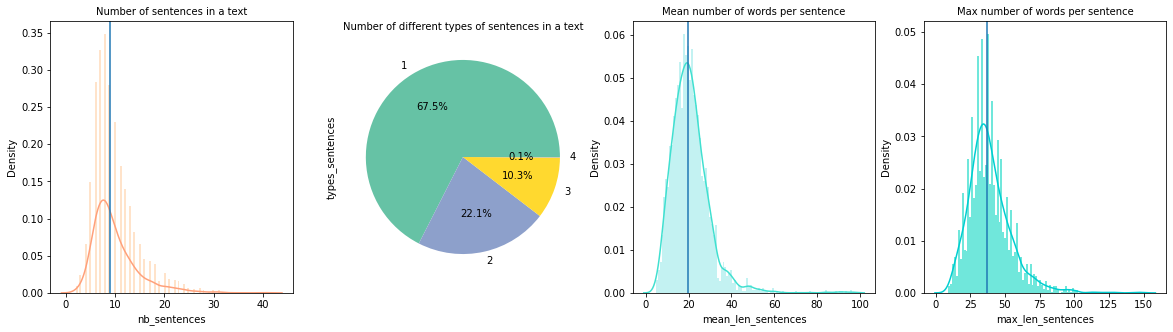

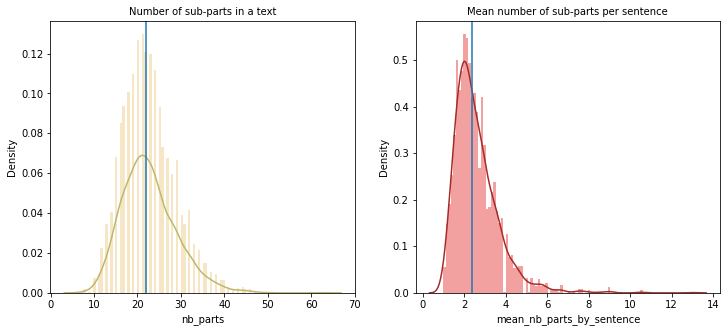

In [4]:
# text complexity analysis

def get_parts(text, level='sentence'):
    """return parts of a text 
    if level is sentence, returns list of sentences
    if level is details, uses all signs of ponctuation"""

    if level=='sentence':
        list_replace=['.', '!', '?', '...']
        sep = '.'  
    elif level=='details':
        list_replace=['.', '!', '?', '...', ';', ':']
        sep = ','
    else:
        return []
    
    for char in list_replace:
        text = text.replace(char, sep)
        
    parts = text.split(sep)
    parts = [x for x in parts if x] # cleans empty substrings
    return parts

def count_parts(text, level='sentence'):
    """returns the number of substrings from text
    if the level is 'sentence' (default), counts the number of sentences
    if the level is 'details', uses every sign of ponctuation"""
    parts = get_parts(text, level)
    return len(parts)

def length_parts(text, level='sentence', how='mean'):
    """returns the mean or max length of the substrings in a text
    default level is the sentence analysis"""
    parts = get_parts(text, level)
    len_parts = []
    for s in parts:
        len_parts.append(len(s.split()))

    if how == 'mean':
        return np.mean(len_parts)
    if how == 'max':
        return np.max(len_parts)   
    
def count_parts_in_part(text):
    """for each sentence of the text, find additional ponctuation signs 
    and compute the mean number of 'parts' in the sentences"""
    sentences = get_parts(text, level='sentence')
    nb_parts_by_sentence = []
    for s in sentences:
        nb = count_parts(s, level='details')
        nb_parts_by_sentence.append(nb)
    return np.mean(nb_parts_by_sentence)

def types_sentences(text):
    """returns the number of different sentences types in the text
    from 0 to 4"""
    list_sep = ['.', '!', '?', '...']
    found = []
    for sep in list_sep:
        if sep in text:
            found.append(sep)

    return len(np.unique(found))

# sentences level analysis
data_train['nb_sentences'] = data_train.excerpt.apply(count_parts)
data_train['mean_len_sentences'] = data_train.excerpt.apply(length_parts)
data_train['max_len_sentences'] = data_train.excerpt.apply(length_parts, how='max')
data_train['types_sentences'] = data_train.excerpt.apply(types_sentences)

fix, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(data=data_train, x="nb_sentences", bins=100, ax=ax[0],
             color='peachpuff', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="nb_sentences", color='lightsalmon', ax=ax[0])
ax[0].axvline(np.median(data_train.nb_sentences), 0, np.max(data_train.nb_sentences))
ax[0].set_title('Number of sentences in a text', fontsize=10)

data_types = data_train['types_sentences'].value_counts()
data_types.plot(kind='pie', colormap='Set2', autopct="%.1f%%", ax=ax[1])
ax[1].set_title('Number of different types of sentences in a text', fontsize=10)

sns.histplot(data=data_train, x="mean_len_sentences", bins=100, ax=ax[2],
             color='paleturquoise', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="mean_len_sentences", color='turquoise', ax=ax[2])
ax[2].axvline(np.median(data_train.mean_len_sentences), 0, np.max(data_train.mean_len_sentences))
ax[2].set_title('Mean number of words per sentence', fontsize=10)

sns.histplot(data=data_train, x="max_len_sentences", bins=100, ax=ax[3],
             color='turquoise', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="max_len_sentences", color='darkturquoise', ax=ax[3])
ax[3].axvline(np.median(data_train.max_len_sentences), 0, np.max(data_train.max_len_sentences))
ax[3].set_title('Max number of words per sentence', fontsize=10)


plt.show()

# sub-sentences (details) level analysis
data_train['nb_parts'] = data_train.excerpt.apply(count_parts, level='details')
data_train['mean_nb_parts_by_sentence'] = data_train.excerpt.apply(count_parts_in_part)

fix, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data_train, x="nb_parts", bins=100, ax=ax[0],
             color='wheat', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="nb_parts", color='darkkhaki', ax=ax[0])
ax[0].axvline(np.median(data_train.nb_parts), 0, np.max(data_train.nb_parts))
ax[0].set_title('Number of sub-parts in a text', fontsize=10)

sns.histplot(data=data_train, x="mean_nb_parts_by_sentence", bins=100, ax=ax[1],
             color='lightcoral', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="mean_nb_parts_by_sentence", color='brown', ax=ax[1])
ax[1].axvline(np.median(data_train.mean_nb_parts_by_sentence), 0, np.max(data_train.mean_nb_parts_by_sentence))
ax[1].set_title('Mean number of sub-parts per sentence', fontsize=10)

plt.show()

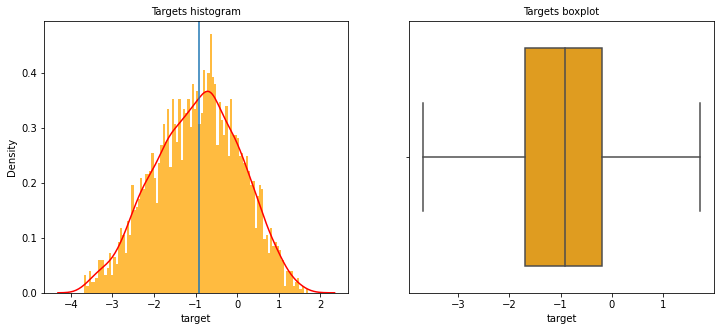

In [5]:
# target labels
labels = data_train['target']

fix, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data_train, x="target", bins=100, ax=ax[0],
             color='orange', edgecolor=None, stat='density')
sns.kdeplot(data=data_train, x="target", ax=ax[0], color='red')
ax[0].axvline(np.median(data_train.target), 0, np.max(data_train.target))
ax[0].set_title('Targets histogram', fontsize=10)

sns.boxplot(x=data_train["target"], ax=ax[1], color='orange')
ax[1].set_title('Targets boxplot', fontsize=10)
plt.show()

In [6]:
data_train.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'nb_words', 'nb_chars', 'interest_words', 'nb_interest_words',
       'nb_sentences', 'mean_len_sentences', 'max_len_sentences',
       'types_sentences', 'nb_parts', 'mean_nb_parts_by_sentence'],
      dtype='object')

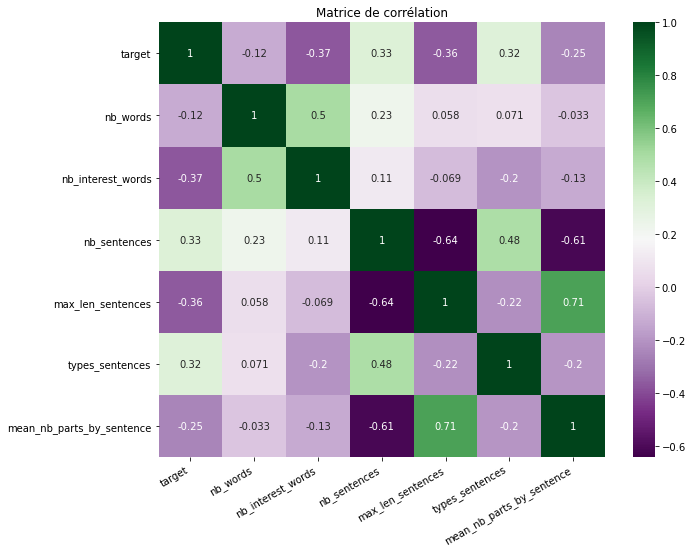

In [7]:
# Correlation between target and text complexity features
data_mat = data_train[['target', 'nb_words', 'nb_interest_words', 'nb_sentences',
                       'max_len_sentences', 'types_sentences', 
                       'mean_nb_parts_by_sentence']]
fig, axes = plt.subplots(figsize= (10,8))
sns.heatmap(data_mat.corr(), annot=True, cmap='PRGn')
plt.xticks(rotation=30, ha='right')
plt.title("Matrice de corrélation")
plt.show()

# Distilbert

In [8]:
# Load pretrained model/tokenizer Distilbert
model_class = ppb.DistilBertModel
tokenizer_class = ppb.DistilBertTokenizer
pretrained_weights = "../input/distilbertbaseuncased/"

tokenizer = tokenizer_class.from_pretrained(pretrained_weights,
                                            do_lower_case=True)
model = model_class.from_pretrained(pretrained_weights)

In [9]:
# choose here if you want to use :
# - full original text (-> excerpt)
# - or preprocessed text (-> interest_words)
use_text = data_train.excerpt
tokenized = use_text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized.shape

(2834,)

In [10]:
# padding : add zeros to build same shapes texts
max_len = 0
min_len = 100000
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
    if len(i) < min_len:
        min_len = len(i)
print('length of texts : {} -> {}'.format(min_len, max_len))

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print('texts shape :', padded.shape)

# build attention_mask to focus on real tokens (cf padding)
attention_mask = np.where(padded != 0, 1, 0)

length of texts : 158 -> 314
texts shape : (2834, 314)


In [11]:
# apply pretrained distilbert model to extract features
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

last_hidden_states = []
batch_size = 200

start = time.time()
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
        print('{} / {}'.format(i, len(input_ids)))
        ins = input_ids[i:i+batch_size]
        atts = attention_mask[i:i+batch_size]
        h = model(ins, attention_mask=atts)
        last_hidden_states.extend(h[0])

print('elapsed time : ', time.time() - start)
print('hidden states : ', len(last_hidden_states))

0 / 2834
200 / 2834
400 / 2834
600 / 2834
800 / 2834
1000 / 2834
1200 / 2834
1400 / 2834
1600 / 2834
1800 / 2834
2000 / 2834
2200 / 2834
2400 / 2834
2600 / 2834
2800 / 2834
elapsed time :  999.2312841415405
hidden states :  2834


# Regression

In [12]:
def show_res(yTest, yPred):
    """plots result curves"""
    fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    xmin = np.min(yTest)-1
    xmax = np.max(yTest)+1
    axes[0].scatter(yTest, yPred, color='coral', s=1.5)
    axes[0].plot([xmin, xmax], [xmin, xmax])
    axes[0].set_xlabel('Y expected')
    axes[0].set_ylabel('Y prediction')
    axes[0].set_title('Prediction / true values')
  
    residuals = yTest - yPred
    moy_residuals = np.mean(residuals)
    lab = 'Mean residuals(' + str(np.round(moy_residuals, decimals=2)) + ')'

    xmin = np.min(yPred) - 1
    xmax = np.max(yPred) + 1
    axes[1].scatter(yPred,residuals, color='red', s=1.5)
    axes[1].plot([xmin, xmax], [0, 0], color='grey', alpha=0.5, linewidth=0.5)
    axes[1].plot([xmin, xmax], [moy_residuals, moy_residuals],
                 color='green',linewidth=0.5, label=lab)
    axes[1].set_xlabel('Y prediction')
    axes[1].set_ylabel('Residuals')
    axes[1].legend()
    axes[1].set_title('Residuals')
    
    plt.show()

In [13]:
# get distilbert features (on CLS token)
features = []
for i in range(len(last_hidden_states)):
    sent = last_hidden_states[i]
    first_hidden = sent[0]
    features.append(first_hidden.numpy())
features = np.array(features)

X = []
add_complexity = False
# add complexity features (cf first analysis) if needed
if add_complexity:
    complexity_features = data_train[['nb_sentences',
                                      'types_sentences',
                                      'mean_nb_parts_by_sentence']]
    for i in range(len(data_train)):
        cur_X = features[i]
        cur_complexity = complexity_features.iloc[i].to_numpy()
        cur_X = np.append(cur_X, cur_complexity)
        X.append(cur_X)
else:
    X = features.copy()
    
print('Number of observations :', len(X))
print('Number of features :', len(X[0]))

# split into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

Number of observations : 2834
Number of features : 768


time (sec) : 32.06
rmse : 0.554


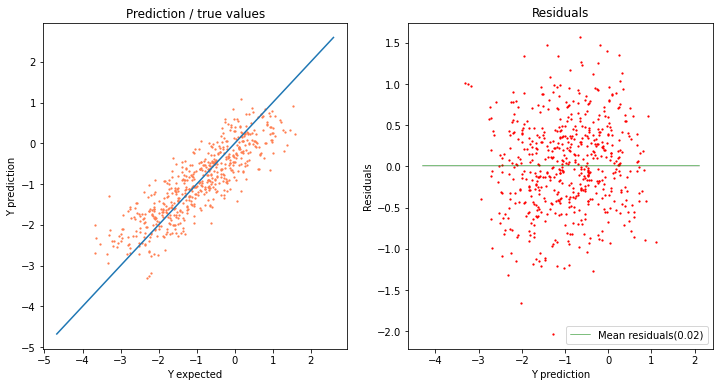

In [14]:
# Ridge polynomial kernel + gridsearch

# parameters
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

score = 'neg_mean_squared_error'

kr_model = GridSearchCV(
        kernel_ridge.KernelRidge(kernel='polynomial'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# training
start_time = time.time()
kr_model.fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction
y_pred = kr_model.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# results
print('time (sec) :', round(elapsed, 2))
print('rmse :', round(rmse, 3))
show_res(y_test, y_pred)

# Test set (7 entries)

Apply the same transformations to test set as the training set (no preprocessing, no complexity features added)

In [15]:
test_file = '../input/commonlitreadabilityprize/test.csv'
data_test =  pd.read_csv(test_file)

# tokenisation on full text
tokenized_test = data_test.excerpt.str.lower().apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True)))

# padding and attention mask
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)
padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
attention_mask_test = np.where(padded_test != 0, 1, 0)

# compute features
input_ids = torch.tensor(padded_test)  
attention_mask = torch.tensor(attention_mask_test)

last_hidden_states_test = []
batch_size = 200

start = time.time()
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
        print('{} / {}'.format(i, len(input_ids)))
        ins = input_ids[i:i+batch_size]
        atts = attention_mask[i:i+batch_size]
        h = model(ins, attention_mask=atts)
        last_hidden_states_test.extend(h[0])
          
print('elapsed time : ', time.time() - start)
print('hidden states : ', len(last_hidden_states_test))

0 / 7
elapsed time :  1.242715835571289
hidden states :  7


In [16]:
# get test features
X_test = []
for i in range(len(last_hidden_states_test)):
    sent = last_hidden_states_test[i]
    first_hidden = sent[0]
    X_test.append(first_hidden.numpy())
X_test = np.array(X_test)

# prediction
y_test = kr_model.predict(X_test)

# submission file
submission_df = pd.DataFrame({'id': data_test.id, 'target': 0})
submission_df.target = y_test

submission_file = 'submission.csv'
submission_df.to_csv(submission_file, index=False)

submission_df

,id,target
0,c0f722661,-0.709599
1,f0953f0a5,-0.103552
2,0df072751,-0.310742
3,04caf4e0c,-2.838187
4,0e63f8bea,-1.778939
5,12537fe78,-1.217964
6,965e592c0,-0.381122
